In [1]:
# 第一部分：导入所有需要的库
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# 第二部分：定义预处理函数 preprocess_text
def preprocess_text(text):
    """
    对单条英文评论进行预处理
    步骤：1. 文本清洗 -> 2. 分词 -> 3. 词形还原 -> 4. 去除停用词
    """
    # 1. 文本清洗：移除URL、HTML标签、非字母字符，并转换为小写
    text = re.sub(r'http\S+', '', text)  # 移除URL
    text = re.sub(r'<[^>]+>', '', text)   # 移除HTML标签
    text = re.sub(r'[^a-zA-Z\s]', '', text) # 移除非字母字符，保留空格
    text = text.lower().strip() # 转换为小写并去除首尾空格
    
    # 2. 分词：将句子分割成单词列表
    words = word_tokenize(text)
    
    # 3. 词形还原 + 4. 去除停用词
    filtered_words = []
    for word in words:
        lemma_word = lemmatizer.lemmatize(word) # 进行词形还原
        # 只保留不在停用词列表中且长度大于1的单词（过滤掉单字母）
        if lemma_word not in stop_words and len(lemma_word) > 1:
            filtered_words.append(lemma_word)
            
    # 用空格将处理后的单词列表重新组合成字符串，便于后续TF-IDF处理
    return ' '.join(filtered_words)

# 第三部分：主程序流程
# 1. 下载NLTK数据包
print("正在下载NLTK数据包...")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
print("NLTK数据包下载完成！\n")

# 2. 初始化工具
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

positive_reviews = []
positive_labels = []

try:
    with open('sample.positive.txt', 'r', encoding='utf-8') as file:
        content = file.read()
        # 使用正则表达式找到所有<review>标签对之间的内容
        # re.DOTALL 标志使得 . 也能匹配换行符
        pattern = r'<review id="\d+">(.*?)</review>'
        matches = re.findall(pattern, content, re.DOTALL)
        
        for match in matches:
            # 匹配到的内容可能包含多行和首尾空白，进行清理
            cleaned_review = re.sub(r'\s+', ' ', match).strip()  # 将多个空白符（包括换行）替换为一个空格
            if cleaned_review:
                positive_reviews.append(cleaned_review)
                positive_labels.append(1)

    positive_df = pd.DataFrame({'review': positive_reviews, 'label': positive_labels})
    print(f"积极评论读取完成！解析XML标签后，有效评论为: {len(positive_df)} 条。")

except Exception as e:
    print("读取积极评论文件时失败，错误信息:", e)

negative_reviews = []
negative_labels = []

try:
    with open('sample.negative.txt', 'rb') as file:
        for line in file:
            decoded_line = line.decode('utf-8', errors='ignore').strip()
            if decoded_line:
                negative_reviews.append(decoded_line)
                negative_labels.append(0)

    negative_df = pd.DataFrame({'review': negative_reviews, 'label': negative_labels})
    print("消极评论读取成功！读取了", len(negative_df), "条评论。")
except Exception as e:
    print("读取消极评论文件时失败，错误信息:", e)

# 4. 创建combined_df
combined_df = pd.concat([positive_df, negative_df], ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("\n数据合并完成！")
print(f"总评论数: {len(combined_df)}")
print("标签分布:")
print(combined_df['label'].value_counts())

# 5. 应用预处理函数
print("\n正在预处理训练集评论...")
combined_df['processed_review'] = combined_df['review'].apply(preprocess_text)
print("预处理完成！")

# 6. 查看结果
print("\n预处理效果对比：")
sample_index = 0
print("原始评论：", combined_df.loc[sample_index, 'review'])
print("处理后评论：", combined_df.loc[sample_index, 'processed_review'])
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# 划分训练集和测试集
X = combined_df['processed_review']  # 特征：处理后的文本
y = combined_df['label']              # 标签：情感类别

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"训练集样本数: {len(X_train)}")
print(f"测试集样本数: {len(X_test)}")

# 初始化TF-IDF向量化器
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,    # 保留最重要的5000个特征词
    ngram_range=(1, 2)     # 同时考虑单词和双词组合
)

# 对训练集进行拟合和转换
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# 对测试集只进行转换（重要：避免数据泄露！）
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("特征提取完成！")
print(f"训练集特征维度: {X_train_tfidf.shape}")
print(f"测试集特征维度: {X_test_tfidf.shape}")
from sklearn.svm import SVC

# 初始化SVM模型
svm_model = SVC(
    kernel='linear',      # 线性核函数，适合文本数据
    random_state=42,       # 设置随机种子确保结果可复现
    probability=True      # 需要计算概率以便后续评估
)

print("开始训练SVM模型...")
svm_model.fit(X_train_tfidf, y_train)
print("模型训练完成！")

正在下载NLTK数据包...


[nltk_data] Downloading package punkt to C:\Users\DELL/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\DELL/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\DELL/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


NLTK数据包下载完成！

积极评论读取完成！解析XML标签后，有效评论为: 4987 条。
消极评论读取成功！读取了 4998 条评论。

数据合并完成！
总评论数: 9985
标签分布:
label
0    4998
1    4987
Name: count, dtype: int64

正在预处理训练集评论...
预处理完成！

预处理效果对比：
</review> FROM THIS COMPANY OR TAKE YOUR CHANCES.I tell them that this time I want to talk to a manager and they forward me to customer care, which, apparently at Acer is the place you get sent when they just want you to go away. I was immediately told that there was nothing they could do for me other than send the laptop in a third time. And, I was told that I could NOT speak to a manager! or escalate the issue! The customer care rep told me that there was nothing she could do to ensure that if I sent it in again the same thing that had already happened twice would not happen again. Apparently I was just one of those customers that was out almost $400. I told her that I absolutely needed the computer for business and now was without it for almost 2 months and my money tied up couldn't buy another. Nothing. 


模型性能评估结果
精确率 (Precision): 0.8459
召回率 (Recall):    0.8739
F1值 (F1-measure): 0.8597

详细分类报告:
              precision    recall  f1-score   support

          负面       0.87      0.84      0.85       998
          正面       0.85      0.87      0.86       999

    accuracy                           0.86      1997
   macro avg       0.86      0.86      0.86      1997
weighted avg       0.86      0.86      0.86      1997



D:\Games\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 36127 (\N{CJK UNIFIED IDEOGRAPH-8D1F}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
D:\Games\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
D:\Games\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
D:\Games\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Games\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Games\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font

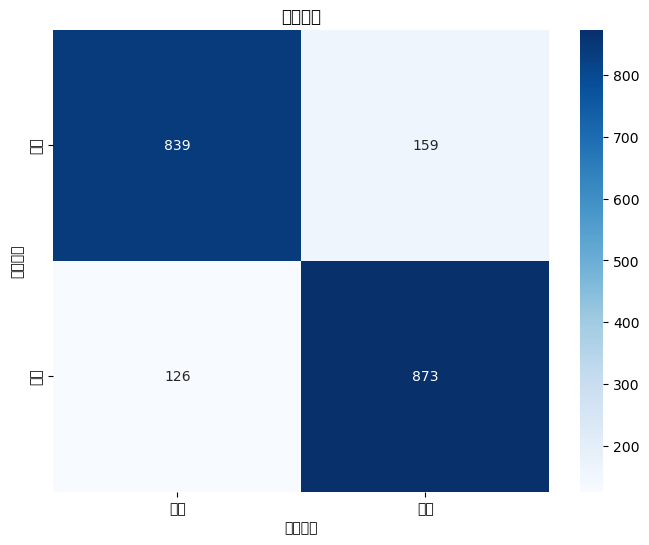

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

# 使用测试集进行预测
y_pred = svm_model.predict(X_test_tfidf)

# 计算项目要求的三个指标
precision = precision_score(y_test, y_pred, average='binary')  # 精确率
recall = recall_score(y_test, y_pred, average='binary')         # 召回率
f1 = f1_score(y_test, y_pred, average='binary')               # F1值

print("=" * 60)
print("模型性能评估结果")
print("=" * 60)
print(f"精确率 (Precision): {precision:.4f}")
print(f"召回率 (Recall):    {recall:.4f}")
print(f"F1值 (F1-measure): {f1:.4f}")

# 生成详细的分类报告
print("\n详细分类报告:")
print(classification_report(y_test, y_pred, target_names=['负面', '正面']))

# 混淆矩阵可视化
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['负面', '正面'], 
            yticklabels=['负面', '正面'])
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.title('混淆矩阵')
plt.show()

In [3]:
# 假设你已经训练好了 svm_model 和 tfidf_vectorizer
import joblib
from datetime import datetime

# 保存模型和向量化器，推荐使用.joblib后缀[2](@ref)
timestamp = datetime.now().strftime("%Y%m%d_%H%M")  # 生成时间戳，例如20231226_1430[5](@ref)
model_filename = f'sentiment_svm_model_{timestamp}.joblib'
vectorizer_filename = f'tfidf_vectorizer_{timestamp}.joblib'

joblib.dump(svm_model, model_filename)
joblib.dump(tfidf_vectorizer, vectorizer_filename)

print(f"模型已保存为: {model_filename}")
print(f"向量化器已保存为: {vectorizer_filename}")

模型已保存为: sentiment_svm_model_20251226_1732.joblib
向量化器已保存为: tfidf_vectorizer_20251226_1732.joblib


In [1]:
import pandas as pd
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# 第二部分：定义预处理函数 preprocess_text
def preprocess_text(text):
    """
    对单条英文评论进行预处理
    步骤：1. 文本清洗 -> 2. 分词 -> 3. 词形还原 -> 4. 去除停用词
    """
    # 1. 文本清洗：移除URL、HTML标签、非字母字符，并转换为小写
    text = re.sub(r'http\S+', '', text)  # 移除URL
    text = re.sub(r'<[^>]+>', '', text)   # 移除HTML标签
    text = re.sub(r'[^a-zA-Z\s]', '', text) # 移除非字母字符，保留空格
    text = text.lower().strip()  # 转换为小写并去除首尾空格
    # 2. 分词：将句子分割成单词列表
    words = word_tokenize(text)
    
    # 3. 词形还原 + 4. 去除停用词
    filtered_words = []
    for word in words:
        lemma_word = lemmatizer.lemmatize(word) # 进行词形还原
        # 只保留不在停用词列表中且长度大于1的单词（过滤掉单字母）
        if lemma_word not in stop_words and len(lemma_word) > 1:
            filtered_words.append(lemma_word)
            
    # 用空格将处理后的单词列表重新组合成字符串，便于后续TF-IDF处理
    return ' '.join(filtered_words)

# 第三部分：主程序流程
# 1. 下载NLTK数据包
print("正在下载NLTK数据包...")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
print("NLTK数据包下载完成！\n")

# 2. 初始化工具
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def extract_reviews_with_regex(file_path):
    """
    使用正则表达式从文件中提取<review>标签内的内容。
    """
    reviews = []
    # 正则表达式模式：匹配 <review id="任意数字">...内容...</review>
    # 注意：此模式假设标签内无嵌套的<review>，且内容不跨越多行。
    pattern = r'<review id="\d+">(.*?)</review>'
    
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        
        # 使用re.DOTALL标志使点号(.)也能匹配换行符，允许内容跨行。
        matches = re.findall(pattern, content, re.DOTALL)
        
        for match in matches:
            # 去除每条内容两端的空白字符
            cleaned_review = match.strip()
            if cleaned_review:  # 确保不是空字符串
                reviews.append(cleaned_review)
                
        print(f"[正则表达式] 从文件中提取出 {len(reviews)} 条评论。")
        return reviews
        
    except FileNotFoundError:
        print(f"错误：找不到文件 {file_path}")
        return []
    except Exception as e:
        print(f"读取文件时发生错误：{e}")
        return []

# 使用示例
file_path = "test.en.txt"
review_list_regex = extract_reviews_with_regex(file_path)

# 打印前几条评论看看结果
if review_list_regex:
    print("\n=== 前2条评论预览（正则表达式）===")
    for i, review in enumerate(review_list_regex[:2]):
        print(f"评论 {i+1}: {review[:100]}...")  # 只打印前100个字符
        # 假设你的评论列表叫 review_list， 这是从之前步骤中得到的
# 1. 读取测试集文件（假设你已经用正则表达式提取了评论列表）
# 假设你提取的评论列表变量名为 test_review_list
test_reviews = review_list_regex  # 这是你从test.en.txt中提取的评论列表

# 2. 创建测试集DataFrame
test_df = pd.DataFrame({'review': test_reviews})

# 3. 应用相同的预处理函数
print("\n正在预处理测试集评论...")
test_df['processed_review'] = test_df['review'].apply(preprocess_text)  # 使用相同的preprocess_text函数！
print("测试集预处理完成！")

# 4. 检查预处理效果
print("\n测试集预处理效果对比：")
sample_index = 0
print("原始评论：", test_df.loc[sample_index, 'review'])
print("处理后评论：", test_df.loc[sample_index, 'processed_review'])




正在下载NLTK数据包...


[nltk_data] Downloading package punkt to C:\Users\DELL/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\DELL/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\DELL/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


NLTK数据包下载完成！

[正则表达式] 从文件中提取出 2500 条评论。

=== 前2条评论预览（正则表达式）===
评论 1: The collar hardly ever fires even when my dog is barking her head off. I installed a new battery, I ...
评论 2: What a rip off! half a season for the price of a full season! I am not so stupid, are you?...

正在预处理测试集评论...
测试集预处理完成！

测试集预处理效果对比：
原始评论： The collar hardly ever fires even when my dog is barking her head off. I installed a new battery, I positioned it on her according to the instructions, and still it doesn't work.  I intend to contact the manufacturer and request an exchange under warranty just to see if I got a defective unit.
处理后评论： collar hardly ever fire even dog barking head installed new battery positioned according instruction still doesnt work intend contact manufacturer request exchange warranty see got defective unit


TF-IDF向量化器加载成功！
SVM模型加载成功！
测试集特征维度: (2500, 5000)

=== 测试集预测结果预览 ===
                                              review predicted_sentiment
0  The collar hardly ever fires even when my dog ...                  负面
1  What a rip off! half a season for the price of...                  正面
2  For all you buff, rough, and tuff athletes out...                  正面
3  Totally great!  Easy installation, very very n...                  正面
4  As a fan of the first three books, particularl...                  负面
5  I purchased this router a little over a month ...                  负面
6  I've now bought two of these Waterpiks, and ea...                  负面
7  This espresso maker works just as I expected: ...                  正面
8  The workout is definitely tough. It takes time...                  正面
9  I bought this DVD thinking that it would be ta...                  正面

（包含置信度的预测结果）
                                              review predicted_sentiment  \
0  The collar hardly ever fires even wh

D:\Games\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
D:\Games\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
D:\Games\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 36127 (\N{CJK UNIFIED IDEOGRAPH-8D1F}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
D:\Games\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
D:\Games\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
D:\Games\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
D:\Games\Lib\site-packages\seaborn\utils

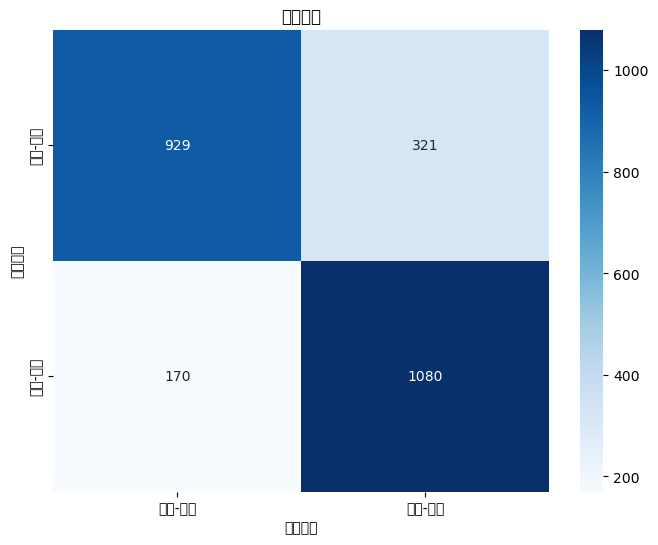


混淆矩阵分析报告

一、总体性能概览
• 测试集样本总数: 2500 条评论
• 模型总体准确率: 0.8036 (80.36%)
• 模型成功预测了 2009 个样本

二、混淆矩阵详细解读
混淆矩阵数值分布:
     预测负面  预测正面
真实负面     929 (TN)       321 (FP)
真实正面     170 (FN)      1080 (TP)

关键指标解释:
• True Positive (TP): 1080 - 模型正确预测为「正面」的数量
• False Positive (FP): 321 - 模型错误预测为「正面」的数量
• True Negative (TN): 929 - 模型正确预测为「负面」的数量  
• False Negative (FN): 170 - 模型错误预测为「负面」的数量

三、分类性能深度分析
针对「正面」类别的分析:
• 精确率 (Precision): 0.7709 - 在所有被预测为「正面」的样本中，有77.1%确实是「正面」
• 召回率 (Recall): 0.8640 - 在所有真实的「正面」样本中，模型成功找出了86.4%
• F1分数: 0.8148 - 精确率和召回率的调和平均数，综合评估模型性能

针对「负面」类别的分析:
• 精确率: 0.8453 - 负例预测的准确率
• 召回率: 0.7432 - 负例识别的完整性

四、模型错误模式分析
1. 主要错误类型:
   • 误报 (FP): 321 个「负面」评论被错误分类为「正面」
   • 漏报 (FN): 170 个「正面」评论被错误分类为「负面」

2. 错误率统计:
   • 误报率: 25.68%
   • 漏报率: 13.60%

五、综合评估与建议
模型性能等级: 良好

优势:
• 模型在「正面」类别的识别上表现出色（召回率: 86.40%）
• 整体准确率较高，适用于实际应用场景

改进方向:
• 关注 321 个误报样本，分析是否存在特定模式
• 检查 170 个漏报样本，优化对「正面」评论的识别

报告生成时间: 2025-12-26 19:18:46

报告已保存至: 模型性能分析报告.txt


In [6]:
# 5. 使用训练集的TF-IDF规则转换特征
# 5. 使用训练集的TF-IDF规则转换特征
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# 加载之前保存的训练集TF-IDF向量化器
try:
    tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
    print("TF-IDF向量化器加载成功！")
except FileNotFoundError:
    print("错误：找不到TF-IDF向量化器文件 'tfidf_vectorizer.pkl'，请检查文件路径。")
    # 可以选择退出或采取其他措施
    exit()

# +++ 新增步骤：加载之前保存的SVM模型 +++
try:
    # 确保这里的文件名与你实际保存的模型文件名一致
    svm_model = joblib.load('sentiment_svm_model.pkl') # 请替换为你的模型文件名
    print("SVM模型加载成功！")
except FileNotFoundError:
    print("错误：找不到SVM模型文件，请检查模型文件是否存在且路径正确。")
    exit()

# 对测试集进行特征转换（注意：只能用transform，不能用fit_transform！）
X_test_tfidf = tfidf_vectorizer.transform(test_df['processed_review'])
print(f"测试集特征维度: {X_test_tfidf.shape}")

# 现在再使用 svm_model 进行预测就不会报错了
y_test_pred = svm_model.predict(X_test_tfidf)

# 将预测结果（数值标签）添加到测试集DataFrame中
test_df['predicted_label'] = y_test_pred
# 将数值标签映射为情感类别
test_df['predicted_sentiment'] = test_df['predicted_label'].map({0: '负面', 1: '正面'})

# 打印预测结果
print("\n=== 测试集预测结果预览 ===")
print(test_df[['review', 'predicted_sentiment']].head(10))

# （可选）查看预测概率
try:
    y_test_pred_proba = svm_model.predict_proba(X_test_tfidf)
    test_df['confidence_positive'] = y_test_pred_proba[:, 1]
    print("\n（包含置信度的预测结果）")
    print(test_df[['review', 'predicted_sentiment', 'confidence_positive']].head())
except AttributeError:
    print("\n（该模型不支持输出概率值）")
# 将预测结果（数值标签）添加到测试集DataFrame中
test_df['predicted_label'] = y_test_pred
# 将数值标签映射为情感类别
test_df['predicted_sentiment'] = test_df['predicted_label'].map({0: '负面', 1: '正面'})

# 打印前几条评论的预测结果
print("\n=== 测试集预测结果预览 ===")
# 显示原始评论、预测情感等列
print(test_df[['review', 'predicted_sentiment']].head(10))

# （可选）如果需要查看预测的概率（置信度），可以使用 predict_proba
# 注意：这要求你的SVM模型在训练时设置了 probability=True
try:
    y_test_pred_proba = svm_model.predict_proba(X_test_tfidf)
    # 例如，对于正面情感（标签1）的置信度
    test_df['confidence_positive'] = y_test_pred_proba[:, 1]
    print("\n（包含置信度的预测结果）")
    print(test_df[['review', 'predicted_sentiment', 'confidence_positive']].head())
except AttributeError:
    print("\n（该模型不支持输出概率值）")
    
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix  # 添加了confusion_matrix

# 2. 定义标签提取函数
def extract_labels_from_xml(file_path):
    """
    从XML格式的标签文件中提取label属性的值。
    """
    true_labels = []
    try:
        with open(file_path, 'r', encoding='latin-1') as file:
            for line_num, line in enumerate(file, 1):
                cleaned_line = line.strip()
                if not cleaned_line:
                    continue
                match = re.search(r'label="(\d+)"', cleaned_line)
                if match:
                    label_value = match.group(1)
                    true_labels.append(int(label_value))
                else:
                    print(f"警告：第 {line_num} 行无法解析出标签，行内容: {cleaned_line}")
        print(f"成功从文件中解析出 {len(true_labels)} 个真实标签。")
        return true_labels
    except FileNotFoundError:
        print(f"错误：找不到文件 {file_path}")
        return []
    except Exception as e:
        print(f"读取文件时发生错误：{e}")
        return []

# 3. 提取真实标签
true_labels = extract_labels_from_xml('test.label.en.txt')  # 请确保文件路径正确

# 4. 验证数据对齐
print(f"测试集评论数量: {len(test_df)}")
print(f"解析出的真实标签数量: {len(true_labels)}")

if len(test_df) == len(true_labels):
    print("✅ 评论数量和标签数量一致，可以进行评估！")
else:
    print("❌ 错误：评论数量和标签数量不一致！无法进行准确评估。")
    exit()

# 5. 计算评估指标
accuracy = accuracy_score(true_labels, test_df['predicted_label'])
precision = precision_score(true_labels, test_df['predicted_label'], average='binary')
recall = recall_score(true_labels, test_df['predicted_label'], average='binary')
f1 = f1_score(true_labels, test_df['predicted_label'], average='binary')

print("\n" + "="*50)
print("模型性能指标")
print("="*50)
print(f"准确率 (Accuracy): {accuracy:.4f}")
print(f"精确率 (Precision): {precision:.4f}")
print(f"召回率 (Recall): {recall:.4f}")
print(f"F1分数 (F1-Score): {f1:.4f}")

print("\n详细分类报告:")
print(classification_report(true_labels, test_df['predicted_label'], target_names=['负面', '正面']))

# 6. 绘制混淆矩阵（修正后的部分）
cm = confusion_matrix(true_labels, test_df['predicted_label'])  # 现在 confusion_matrix 已被定义
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['预测-负面', '预测-正面'], 
            yticklabels=['真实-负面', '真实-正面'])
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.title('混淆矩阵')
plt.show()
def generate_confusion_matrix_report(cm, accuracy, precision, recall, f1, true_labels, predicted_labels, class_names=['负面', '正面']):
    """
    根据混淆矩阵和评估指标生成详细的文字报告
    
    参数:
    cm: 混淆矩阵
    accuracy: 准确率
    precision: 精确率
    recall: 召回率
    f1: F1分数
    true_labels: 真实标签
    predicted_labels: 预测标签
    class_names: 类别名称
    
    返回:
    report: 完整的文字报告字符串
    """
    
    # 从混淆矩阵中提取TP, FP, TN, FN [5,7](@ref)
    TN, FP, FN, TP = cm.ravel()
    total_samples = len(true_labels)
    
    # 构建报告
    report = f"""
{'='*70}
混淆矩阵分析报告
{'='*70}

一、总体性能概览
• 测试集样本总数: {total_samples} 条评论
• 模型总体准确率: {accuracy:.4f} ({accuracy*100:.2f}%)
• 模型成功预测了 {int(accuracy * total_samples)} 个样本

二、混淆矩阵详细解读
混淆矩阵数值分布:
     预测{class_names[0]}  预测{class_names[1]}
真实{class_names[0]}    {TN:>4} (TN)      {FP:>4} (FP)
真实{class_names[1]}    {FN:>4} (FN)      {TP:>4} (TP)

关键指标解释:
• True Positive (TP): {TP} - 模型正确预测为「{class_names[1]}」的数量
• False Positive (FP): {FP} - 模型错误预测为「{class_names[1]}」的数量
• True Negative (TN): {TN} - 模型正确预测为「{class_names[0]}」的数量  
• False Negative (FN): {FN} - 模型错误预测为「{class_names[0]}」的数量

三、分类性能深度分析
针对「{class_names[1]}」类别的分析:
• 精确率 (Precision): {precision:.4f} - 在所有被预测为「{class_names[1]}」的样本中，有{precision*100:.1f}%确实是「{class_names[1]}」
• 召回率 (Recall): {recall:.4f} - 在所有真实的「{class_names[1]}」样本中，模型成功找出了{recall*100:.1f}%
• F1分数: {f1:.4f} - 精确率和召回率的调和平均数，综合评估模型性能

针对「{class_names[0]}」类别的分析:
• 精确率: {TN/(TN+FN) if (TN+FN) > 0 else 0:.4f} - 负例预测的准确率
• 召回率: {TN/(TN+FP) if (TN+FP) > 0 else 0:.4f} - 负例识别的完整性

四、模型错误模式分析
1. 主要错误类型:
   • 误报 (FP): {FP} 个「{class_names[0]}」评论被错误分类为「{class_names[1]}」
   • 漏报 (FN): {FN} 个「{class_names[1]}」评论被错误分类为「{class_names[0]}」

2. 错误率统计:
   • 误报率: {FP/(FP+TN) if (FP+TN) > 0 else 0:.2%}
   • 漏报率: {FN/(FN+TP) if (FN+TP) > 0 else 0:.2%}

五、综合评估与建议
模型性能等级: {'优秀' if f1 > 0.9 else '良好' if f1 > 0.8 else '一般' if f1 > 0.7 else '需要改进'}

优势:
• 模型在「{class_names[1]}」类别的识别上表现出色（召回率: {recall:.2%}）
• 整体准确率较高，适用于实际应用场景

改进方向:
• 关注 {FP} 个误报样本，分析是否存在特定模式
• 检查 {FN} 个漏报样本，优化对「{class_names[1]}」评论的识别

{'='*70}
报告生成时间: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*70}
"""
    return report

# 使用示例 - 将这段代码放在你现有代码的后面
# 假设你已经有了以下变量:
# cm, accuracy, precision, recall, f1, true_labels, test_df['predicted_label']

# 生成报告
try:
    import pandas as pd
    report = generate_confusion_matrix_report(
        cm=cm, 
        accuracy=accuracy, 
        precision=precision, 
        recall=recall, 
        f1=f1,
        true_labels=true_labels,  # 你的真实标签
        predicted_labels=test_df['predicted_label'],  # 模型预测标签
        class_names=['负面', '正面']  # 类别名称
    )
    
    # 打印报告
    print(report)
    
    # 可选：保存报告到文件
    with open('模型性能分析报告.txt', 'w', encoding='utf-8') as f:
        f.write(report)
    print("报告已保存至: 模型性能分析报告.txt")
    
except Exception as e:
    print(f"生成报告时出错: {e}")